# Running a prediction run for U-Net approach

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Referred: https://github.com/milesial/Pytorch-UNet

In [3]:
import argparse
import logging
import os
import os.path as osp
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from eval import eval_net
from unet import UNet

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

## Training

In [4]:
net = UNet(n_channels=3, n_classes=1, bilinear=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [8]:
dir_img = 'Unet/data/imgs/'
dir_mask = 'Unet/data/masks/'
dir_checkpoint = 'checkpoints/'

def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=0.5):

    dataset = BasicDataset(dir_img, dir_mask, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (1 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)

        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()


In [9]:
# Training run

train_net(net=net,
          device=device,
          epochs=2, 
          batch_size= 1,
          img_scale=0.5,
          val_percent=0.1)

Epoch 2/2: 100%|██████████| 3623/3623 [1:42:56<00:00,  1.70s/img, loss (batch)=0.00664]


## Evaluations

In [11]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset


def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

    return full_mask > out_threshold


In [12]:
def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))

### Getting filenames

In [ ]:
from glob import glob
import random

in_files = glob('Unet/data/imgs/*.jpg')

random.seed(0)
random.shuffle(in_files)

in_files

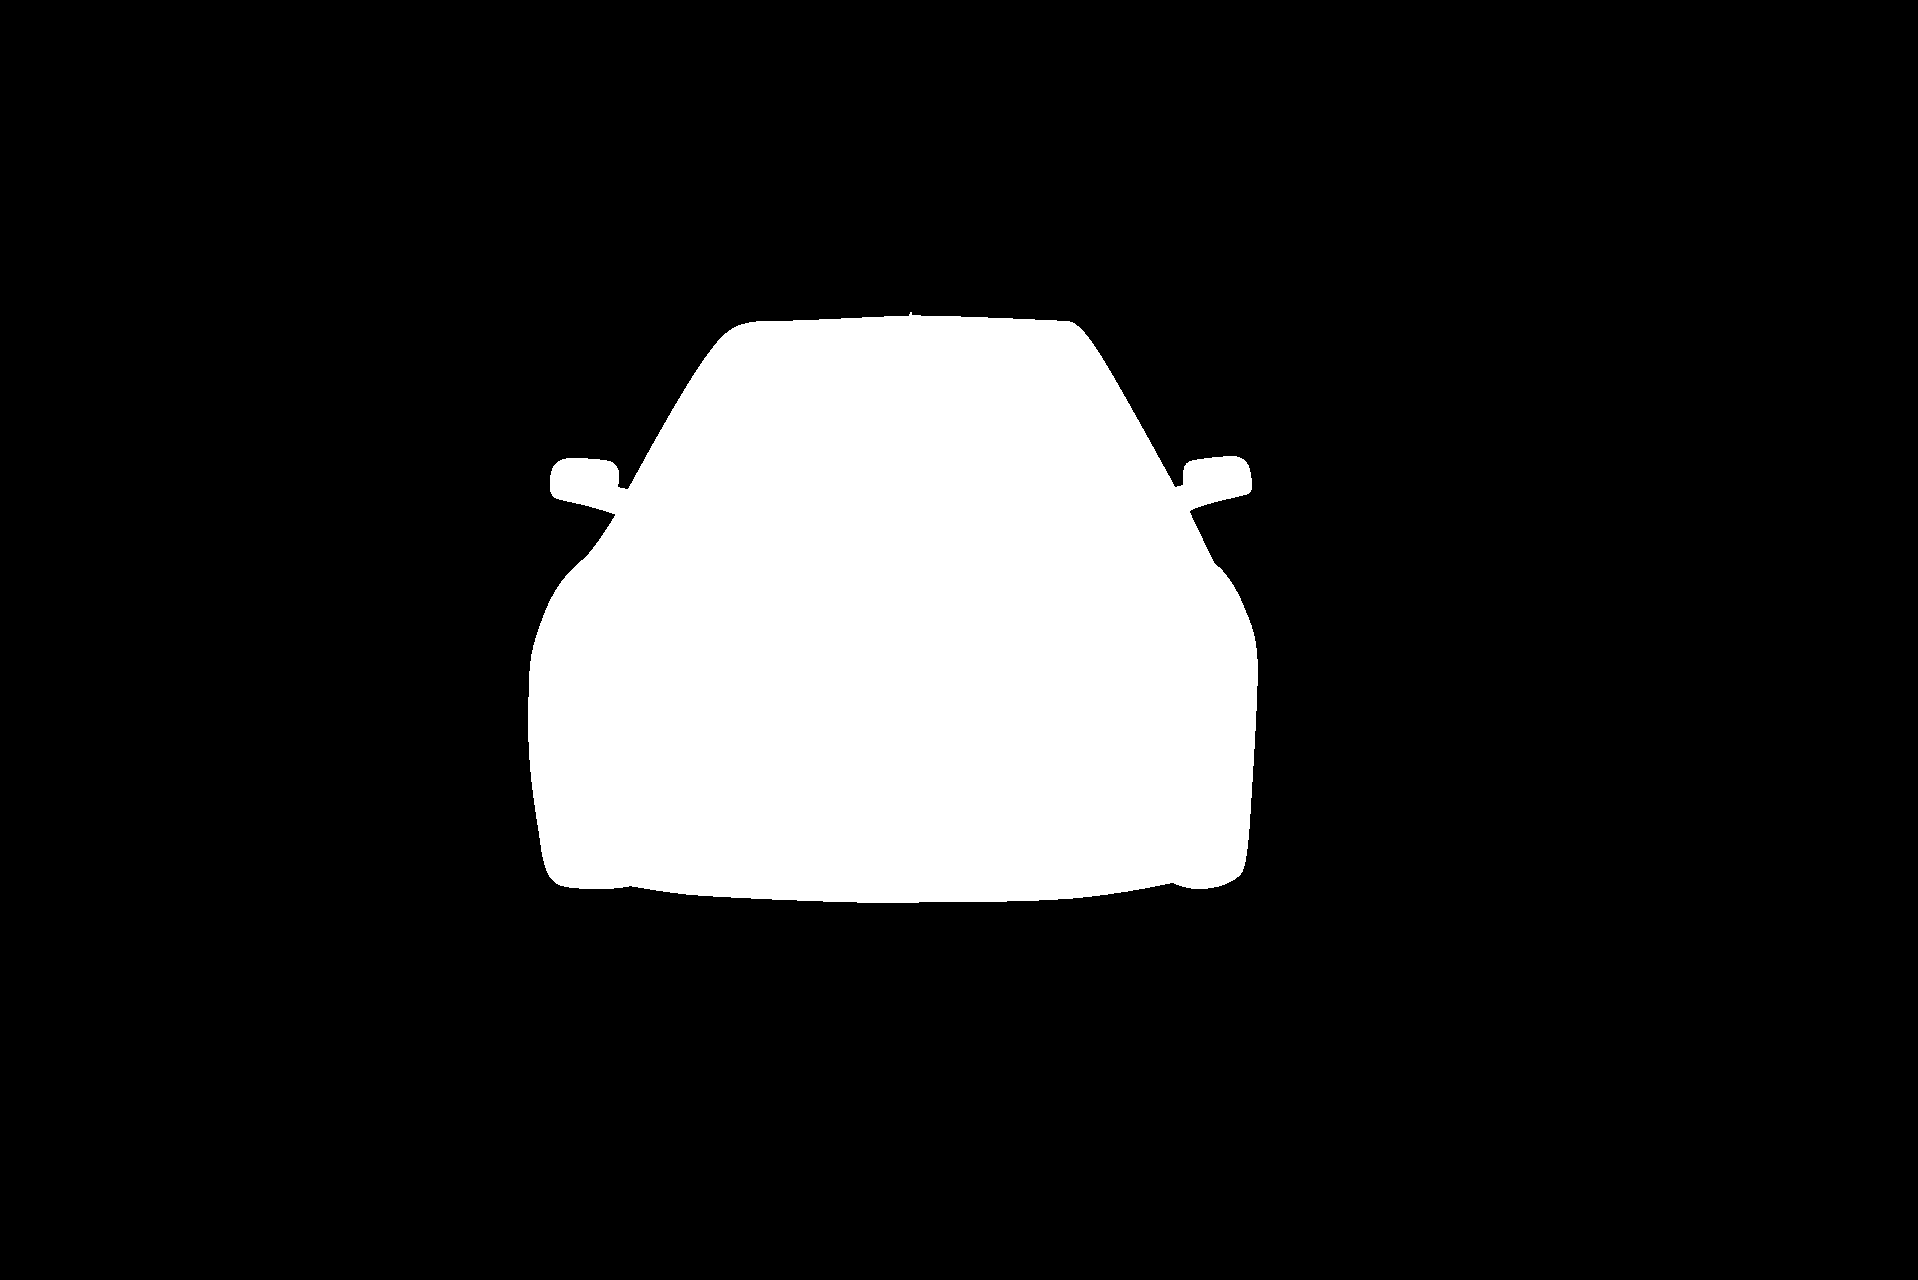

In [32]:
name = os.path.splitext(os.path.basename(in_files[0]))[0]
name

mask_img = Image.open(f'Unet/data/masks/{name}.png')
mask_img

In [ ]:
from PIL import Image

img = Image.open(in_files[0])

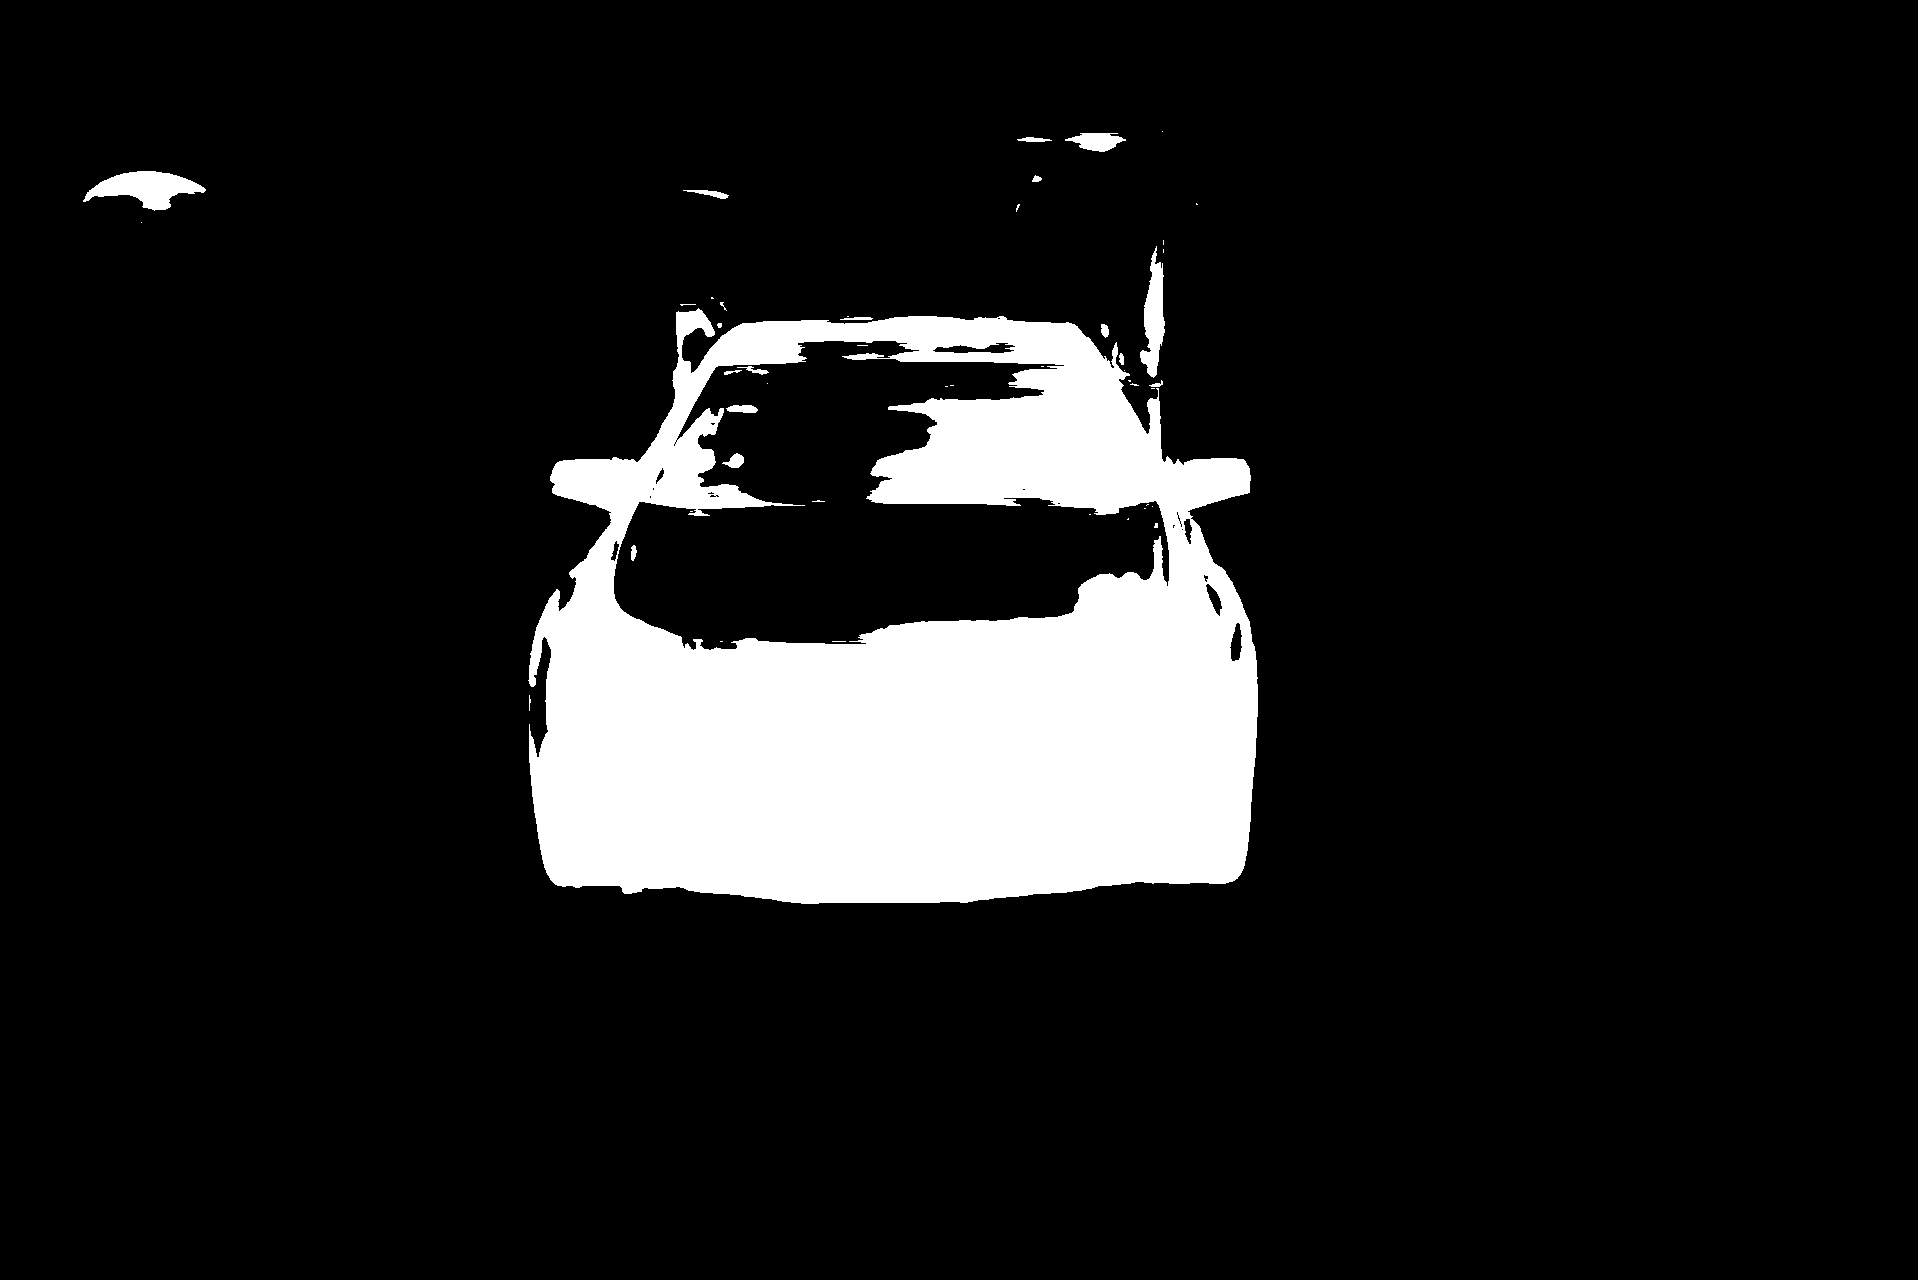

In [26]:
mask = predict_img(net, img, device)
mask_to_image(mask)

In [37]:
from sklearn.metrics import f1_score

def dice_coeff(annotation, mask):
    """The Dice coefficient for our 2 images"""
    
    annotation, mask = annotation.flatten(), mask.flatten()
    return f1_score(annotation, mask)

The scores from the model aren't encouraging. It might need more training epochs for reasonable F-1 scores

In [43]:
def data_splitting_predict(image_folder, mask_folder, train=0.8, valid=0.15, test=0.05):
    
    random.seed(1)    
    dice_coeff_total = 0
    count = 0
    for root, dirs, files in os.walk(image_folder, topdown=False):
        for file in tqdm(files):
            name, ext = osp.splitext(file)

            # Select folder name
            # NOTE: Going through extracting the same images as the data we 
            #       process in SageMaker to evaluate the same files!

            rand = random.random()

            if rand < train:
                continue
                # folder_prefix = 'train'

            elif rand < train+valid:
                continue
                # folder_prefix = 'valid'

            else: 
                pass  # We'll be predicting if it's a test image

            mask_img = Image.open(f'Unet/data/masks/{name}.png')
            mask = predict_img(net, img, device)
            dice_coeff_total += dice_coeff(np.array(mask_img), mask)
            count += 1
    
    dice_coeff_avg = dice_coeff_total / count

    return dice_coeff_avg

dice_coeff_avg = data_splitting_predict('Unet/data/imgs/', 'Unet/data/masks/')

dice_coeff_avg

0.8246054157631991

## Visualizing

In [47]:
import matplotlib.pyplot as plt

In [55]:
def plots(filename, index=None):
    
    img = Image.open(filename)

    name = osp.splitext(osp.basename(filename))[0]

    mask_img = Image.open(f'Unet/data/masks/{name}.png')  # Actual mask
    
    mask = predict_img(net, img, device)  # Prediction

    fig, ax = plt.subplots(2,2, figsize = (15,10))
        
    ax[0,0].imshow(img)
    ax[0,0].title.set_text('Actual')
    ax[0,1].imshow(img)
    ax[0,1].title.set_text('Prediction')
    
    ax[1,0].imshow(mask_img)
    ax[1,1].imshow(mask)    

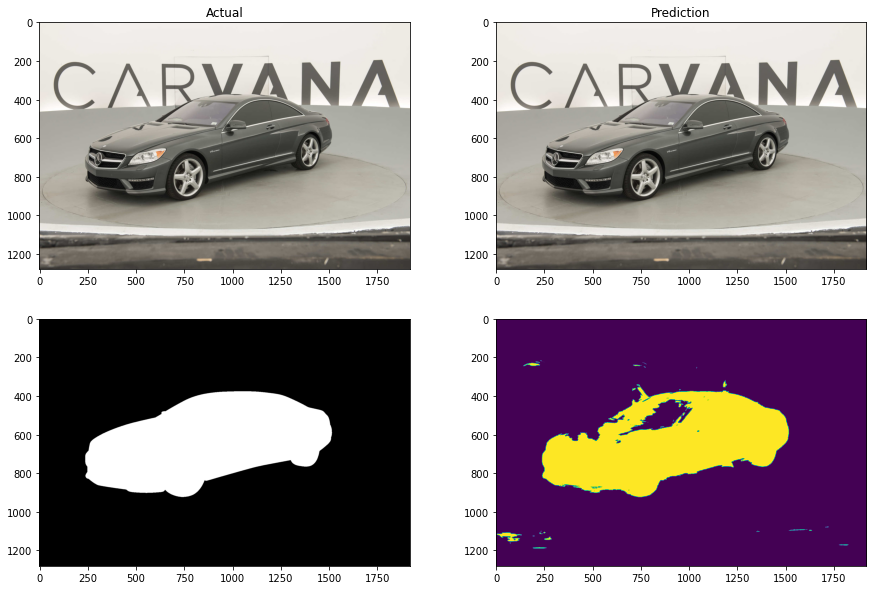

In [56]:
plots(in_files[1])

In general, the model isn't performing well enough:
1. It seems to miss the sharp edges 
2. It gets confused by some of the dark background
3. The prediction always misses the dashboard as part of the car


In our case, using a default model called **semantic-segmentation** by AWS SageMaker might be helpful to improve accuracy.